# Open-loop Feedback Control (OLFC) of the solar home, with Julia/JuMP

This notebook implements Open-loop Feedback Control (OLFC) to minimize the grid energy cost $\sum_k c_{grid}(k).P_{grid}(k)$.

Principle: at each time step, the power dispatch decision is based on solving an optimization problem on a receding horizon like deterministic MPC. The forecast of sun & load power is a *set of trajectories* to represent uncertainty, rather than one single trajectory for deterministic MPC.
However, like in MPC, most of the decision on the horizon is fixed, except for *recourse* variables. Recourses are instantaneous decisions (i.e. which do not affect dynamics) to adapt to each possible value of the uncertain inputs.

Pierre Haessig - last update May 2020

In [1]:
using Printf, Statistics # for mean

# Optimization:
using JuMP
using Clp

# Plotting:
using PyPlot

Import solarhome utility module `Benchutils`, using `bu` as a short alias.

In [2]:
p_utils = joinpath("..","..","utils")
@assert isdir(p_utils)
push!(LOAD_PATH, p_utils)

import Benchutils
const bu = Benchutils

Benchutils

## 1. Load solar home data

(same section as in the [julia_determinist_opt.ipynb](julia_determinist_opt.ipynb) notebook)

In [3]:
params, data = bu.load_data(subset="test");

loading test data (2011-11-29 00:00:00 to 2011-12-28 23:30:00)

### 1.A. Solar home parameters (ratings)

Parameters are fields of the `params` struct:

In [4]:
println("E_rated: $(params.E_rated) kWh")
println("P_pvp: $(params.P_pvp) kWp")
println("P_grid_max: $(params.P_grid_max) kW")

E_rated: 8.0 kWh
P_pvp: 4.0 kWp
P_grid_max: 3.0 kW


### 1.B. Solar home time series

vectors for time, power inputs and grid price

Time vectors

In [5]:
const t = data["t"] # hours
const td = t/24; # days
const dt = t[2] - t[1] # timestep, hours
dt

0.5

In [6]:
const n = length(t)
const ndays = Int(n/48) # days
ndays

30

Power inputs and price

In [7]:
const P_load = data["P_load_sp"]
# scaling of PV production
const P_sun = data["P_sun_1k"]*params.P_pvp;
const c_grid = data["c_grid"];

In [8]:
@printf("Average sun energy: %.2f kWh/d\n", mean(P_sun)*24)
@printf("Average load      : %.2f kWh/d\n", mean(P_load)*24)
@printf("ratio sun/load: %.1f%%", mean(P_sun)/mean(P_load)*100)

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.7%

Demo plot of input data

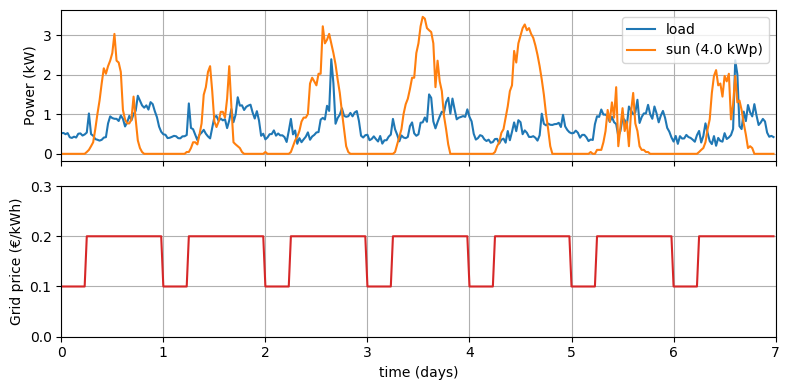

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4), sharex=true)
z = 1:7*48

# Power flow inputs:
ax1.plot(td[z], P_load[z], label="load", color="tab:blue")
ax1.plot(td[z], P_sun[z], label="sun ($(params.P_pvp) kWp)", color="tab:orange")

ax1.legend()
ax1.grid(true)

ax1.set(
    xlim = (0,7),
    ylabel = "Power (kW)"   
)

# Grid price
ax2.plot(td[z], c_grid[z], color="tab:red")

ax2.grid(true)

ax2.set(
    xlim = (0,7),
    ylim = (0,0.3),
    xlabel = "time (days)",
    ylabel = "Grid price (€/kWh)"   
)
fig.tight_layout()

### 1.C. Load learning data

Learning data comes from the month before the test month. It serves to evaluate the expected cost.

trajectories are folded in a 2D array of size `(48, ndays)`

In [10]:
train_data = bu.load_data(subset="train")[2];

loading train data (2011-10-29 00:00:00 to 2011-11-27 23:30:00)

In [74]:
const P_load_tr = reshape(train_data["P_load_sp"], (48,ndays))
# scaling of PV production
const P_sun_tr = reshape(train_data["P_sun_1k"], (48,ndays))*params.P_pvp;

ErrorException: cannot declare P_load_tr constant; it already has a value

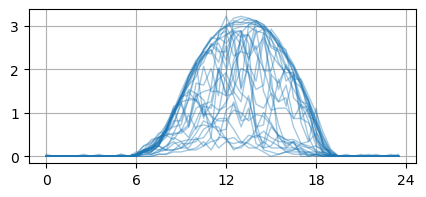

In [73]:
figure(figsize=(5,2))
hod = (0:47)*dt
plot(hod, P_sun_tr, "C0-", lw=1, alpha = 0.4)
xticks([0,6,12,18,24])
grid(true)

## 2. OLFC control function

### 2.A. Scenarion generation function

(replaces the *forecast* function of MPC)

Forecast functions are defined as [closures](https://docs.julialang.org/en/v1/devdocs/functions/index.html#Closures-1), taking instant `k` and horizon length `H` as their only arguments, while accessing other data as global variables. For best performance, Julia's manual recommends that those globals are defined as [constants](https://docs.julialang.org/en/v1/manual/variables-and-scoping/index.html#Constants-1), although it's probably not the critical aspect of MPC performance.

In [75]:
"Remap x to the range 1...48 with modulo operation."
remap_1_48(x) = ((x .- 1) .% 48) .+ 1
print(
    remap_1_48([1,47,48, 49,95,96])
)

[1, 47, 48, 1, 47, 48]

In [77]:
"""
    make_scenarios(H, nscen)

Create a scenarios generation function on an horizon of `H` steps with `nscen` scenarios.

scenarios function takes instant `k` as input
and returns scenarios in a (H, nscen) array
"""
function make_scenarios(H, nscen=ndays)
    @assert nscen <= ndays "nscen must be <= $ndays"
    
    function scenarios(k)
        @assert k <= n "k must be <= $n"
        k_list = remap_1_48(k:k+H-1)
        
        P_load_scen = P_load_tr[k_list, 1:nscen]
        P_sun_scen  =  P_sun_tr[k_list, 1:nscen]
        c_grid_fc   = c_grid[k_list]
        
        # make first instant perfect:
        P_load_scen[1, :] .= P_load[k]
        P_sun_scen[1, :]  .= P_sun[k]

        return P_load_scen, P_sun_scen, c_grid_fc
    end
end

make_scenarios

Test with 3 scenarios on horizon 4:

- scenarios for k=2 corresponds to the shifted scenarios for k=1, except at the first instant where the scenarios equal the actual test data

In [78]:
scenarios_43 = make_scenarios(4, 3)
scenarios_43(1)[1]

4×3 Array{Float64,2}:
 0.52   0.52   0.52
 0.378  0.37   0.426
 0.342  0.328  0.314
 0.342  0.318  0.522

In [79]:
scenarios_43(2)[1]

4×3 Array{Float64,2}:
 0.528  0.528  0.528
 0.342  0.328  0.314
 0.342  0.318  0.522
 0.388  0.356  0.414

### 2.B. MPC decision function

Select the default optimization solver:

In [59]:
const default_optimizer = Clp.Optimizer
# set solver attributes: 
#const default_optimizer = optimizer_with_attributes(Clp.Optimizer, "LogLevel" => 0)

Clp.Optimizer

### Implementation which reuses the JuMP Model

Reusing the optimization model, with:
- [Constraint modifications](http://www.juliaopt.org/JuMP.jl/stable/constraints/#Constraint-modifications-1) (only the right hand side, i.e. the constant $b$ in $a.x ≤ b$)
- Objective update with [JuMP.set_objective_coefficient](http://www.juliaopt.org/JuMP.jl/stable/objective/#JuMP.set_objective_coefficient)

In [87]:
function make_olfc(params, dt, scenarios; optimizer=default_optimizer)
    # Build the base optimization model
    E_rated = params.E_rated
    P_pvp = params.P_pvp
    P_grid_max = params.P_grid_max
    
    # dummy forecast value
    P_load_scen, P_sun_scen, c_grid_fc = scenarios(1)
    
    # horizon and nb of scenaris
    (H, nscen) = size(P_load_scen)
    
    m = Model(optimizer)
    # silence solver output
    set_silent(m)
    
    @variable(m, 0 <= E[1:H+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:H, 1:nscen] <= P_grid_max)
    @variable(m, 0 <= P_curt[1:H, 1:nscen])
    @variable(m, P_sto[1:H])

    @constraint(m, Edyn[k = 1:H], 
        E[k+1] == E[k] + P_sto[k]*dt)
    @constraint(m, Pcons[k = 1:H, s = 1:nscen],
        P_sun_scen[k,s] - P_curt[k,s] + P_grid[k,s] == P_sto[k] + P_load_scen[k,s])
    @constraint(m, P_curt_max[k = 1:H, s = 1:nscen],
        P_curt[k,s] <= P_sun_scen[k,s])

    # dummy present state
    @constraint(m, Eini, E[1] == 0.)
    
    # Objective penalty to avoid non unique solutions
    if H>1
        discount = (1 .- (0:H-1)/(H-1)) # decreasing sequence from 1 to 0 on t=1:H
    else
        discount = 1.
    end
    @variable(m, penal)
    @constraint(m, sum(P_curt .* discount) + sum(P_grid .* discount) <= penal)
    
    # Objective: grid cost + penal
    @objective(m, Min, sum(P_grid .* c_grid_fc) + 1e-4*penal)

    function control_olfc(k, E_k, traj=false)
        # Change the scenarios
        P_load_scen, P_sun_scen, c_grid_fc = scenarios(k)
        
        # Power conservation: adjust net load
        set_normalized_rhs.(m[:Pcons], P_load_scen .- P_sun_scen)
        # Max curtailment
        set_normalized_rhs.(m[:P_curt_max], P_sun_scen)
        # present state
        set_normalized_rhs(m[:Eini], E_k)
        
        # Update objective with new grid price
        set_objective_coefficient.(m, m[:P_grid], c_grid_fc)
        
        # Optimize and check result
        optimize!(m)
        if termination_status(m) == MOI.OPTIMAL

        else
            error("The model was not solved correctly.")
        end
        
        # Decision at present instant k
        P_sto_k  = value(P_sto[1])
        P_grid_k = value(P_grid[1,1])
        P_curt_k = value(P_curt[1,1])
        
        if ~traj
            return P_sto_k, P_grid_k, P_curt_k
        end
        
        # forecasted trajectories of all variables (decision+forecast) and state
        decision_traj = (
            E_sto = value.(E), # state, up to instant H+1
            P_sto = value.(P_sto), # out

            P_load = P_load_fc,

            P_sun  = P_sun_fc,
            P_curt = value.(P_curt),
            P_pv   = P_sun_fc .- value.(P_curt),

            P_grid = value.(P_grid),
            c_grid = c_grid_fc
        )
        return P_sto_k, P_grid_k, P_curt_k, decision_traj
    end
    return control_olfc
end

make_olfc (generic function with 1 method)

In [88]:
scenarios = make_scenarios(2, 3)
control_olfc = make_olfc(params, dt, scenarios);

In [91]:
control_olfc(1,0, false)

(0.0, 0.52, 0.0)

In [94]:
control_olfc(1,8, false)

(-0.52, 0.0, 0.0)

---

*to be continued*...

Timing and allocations are better: 

- without all trajectory output: 4 to 8 ms (11.32 k allocations: 668.656 KiB)
- with all trajectory output: 4 to 8 ms (14.46 k allocations: 1.093 MiB)


In [273]:
forecast = make_daily_mean_forecast(48)
control_mpc2 = make_mpc(params, dt, forecast)
control_mpc2(1,0.)
@time control_mpc2(1, 0., true);

  0.003928 seconds (14.52 k allocations: 1.099 MiB)


### Validation of the control

In [274]:
H = 48
forecast = make_daily_mean_forecast(H)
control_mpc2 = make_mpc(params, dt, forecast);

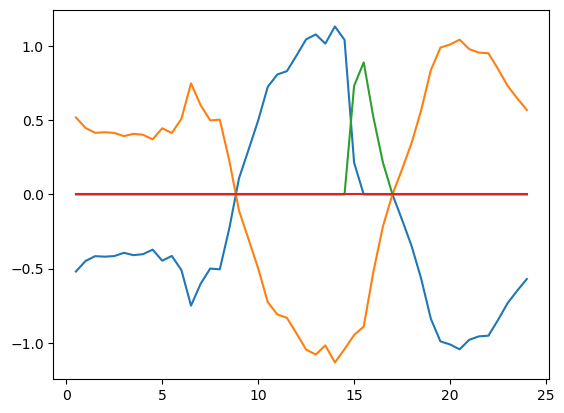

In [275]:
E_k = 7
pred_traj = control_mpc2(1, E_k, true)[4];
tH = (1:H)*dt
plot(tH, pred_traj.P_sto[1:H]);
plot(tH, pred_traj.P_load - pred_traj.P_sun);
plot(tH, pred_traj.P_curt);
plot(tH, pred_traj.P_grid);

## Solar home simulation with MPC

(adapted from the corresponding section of [Julia_rule-based.ipynb](../julia_rule-based/Julia_rule-based.ipynb))

In [350]:
H = 48
forecast = make_daily_mean_forecast(H)
control_mpc2 = make_mpc(params, dt, forecast);

MPC closed loop simulation (takes ~5 s)

In [351]:
P_sto = zeros(n)
E_sto = zeros(n+1)
P_grid = zeros(n)
P_curt = zeros(n)

E_sto[1]= params.E_rated/2

for k in 1:n
    P_sto[k], P_grid[k], P_curt[k] = control_mpc2(k, E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    @assert -1e-3*params.E_rated <= E_sto[k+1] <= 1.001 * params.E_rated "E_sto(k+1) out of bound at k=$k: $(E_sto[k+1])"
end

Collect all trajectory variables

In [352]:
traj = Dict(
    "E_sto" => E_sto[1:end-1], # state 
    "P_sto" => P_sto, # out

    "P_load_sp" => P_load,
    "P_shed" => zero(P_load),
    "P_load" => P_load,

    "P_sun"  => P_sun,
    "P_curt" => P_curt,
    "P_pv"   => P_sun - P_curt,

    "P_grid" => P_grid,
    "c_grid" => c_grid,
);

### Performance statistics

for a 24 hours horizon, using the daily mean forecast:
- grid cost: **0.509 €/d** (better than rule-based: 0.563 €/d)
- grid energy: **3.58 kWh/d** (worse than rule-based: 3.38 kWh/d)

Conclusion: better use of night price, but some enery is wasted (cf. P_curt which is 0.2 kWh/d higher than rule-based)

In [353]:
stats = bu.compute_stats(traj)
bu.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     2.14 kWh/d
P_pv:      13.46 kWh/d

P_sto:      0.03 kWh/d

P_grid:     3.58 kWh/d
C_grid:    0.509 €/d


### Save results in CSV files

In [355]:
bu.save_results("Julia_mpc_24h", params, data, stats, traj)

result files for method "Julia_mpc_24h" written!


### Plots

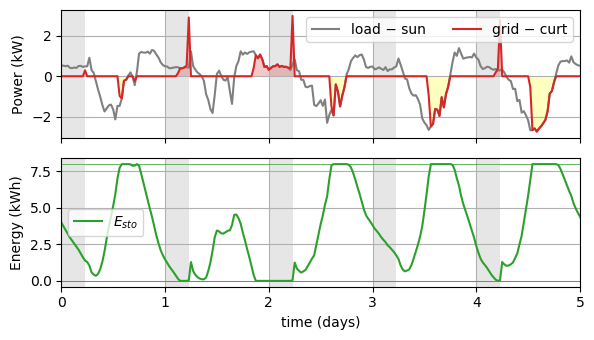

In [280]:
fig, ax = bu.plot_traj(traj, params.E_rated)
ax[1].set_xlim(0, 5);

## Effect of forecast type and horizon

In [281]:
"""
    sim_mpc(forecast)

Simulate MPC control in closed loop with forecast function `forecast`.

NB: the forecast function includes the definition of the forecast horizon `H`.
"""
function sim_mpc(forecast)
    control_mpc2 = make_mpc(params, dt, forecast);

    P_sto = zeros(n)
    E_sto = zeros(n+1)
    P_grid = zeros(n)
    P_curt = zeros(n)

    E_sto[1]= params.E_rated/2

    for k in 1:n
        P_sto[k], P_grid[k], P_curt[k] = control_mpc2(k, E_sto[k])
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        @assert -1e-3*params.E_rated <= E_sto[k+1] <= 1.001 * params.E_rated "E_sto(k+1) out of bound at k=$k: $(E_sto[k+1])"
    end

    # Collect simulated trajectories
    traj = Dict(
        "E_sto" => E_sto[1:end-1], # state 
        "P_sto" => P_sto, # out

        "P_load_sp" => P_load,
        "P_shed" => zero(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => P_curt,
        "P_pv"   => P_sun - P_curt,

        "P_grid" => P_grid,
        "c_grid" => c_grid,
    )

    stats = bu.compute_stats(traj)
    return stats
end

sim_mpc

Test and timing

In [282]:
H = 1
forecast = make_daily_mean_forecast(H)
@time stats = sim_mpc(forecast)

  1.077422 seconds (1.90 M allocations: 116.721 MiB, 4.69% gc time)


Dict{String,Float64} with 9 entries:
  "P_sun"     => 15.6041
  "P_pv"      => 13.6641
  "P_sto"     => 0.0251333
  "P_load"    => 17.017
  "P_shed"    => 0.0
  "P_curt"    => 1.93995
  "P_load_sp" => 17.017
  "P_grid"    => 3.37802
  "C_grid"    => 0.563307

In [255]:
H = 48
forecast_dm  = make_daily_mean_forecast(H)
forecast_per = make_perfect_forecast(H)

stats_dm = sim_mpc(forecast_dm)
stats_per = sim_mpc(forecast_per)

Dict{String,Float64} with 9 entries:
  "P_sun"     => 15.6041
  "P_pv"      => 13.6641
  "P_sto"     => 0.0251333
  "P_load"    => 17.017
  "P_shed"    => 0.0
  "P_curt"    => 1.93995
  "P_load_sp" => 17.017
  "P_grid"    => 3.37802
  "C_grid"    => 0.353734

Experiment design: 
- from 1 to 4 hours: 0.5 h ste (each `H` value)
- from 4 to 24 hours: 1 h step
- from 1 to 2 days: 2 h step

In [327]:
H_list = [1:7; 8:2:44; 48:4:96]
nH = length(H_list)
println("estimated time: $(nH*2*5) s")

estimated time: 390 s


In [328]:
C_grid_per_H = zeros(nH);
C_grid_dm_H = zeros(nH);
P_grid_per_H = zeros(nH);
P_grid_dm_H = zeros(nH);

for (i,H) in enumerate(H_list)
    forecast_dm  = make_daily_mean_forecast(H)
    forecast_per = make_perfect_forecast(H)

    stats_dm = sim_mpc(forecast_dm)
    stats_per = sim_mpc(forecast_per)
    
    # collect grid cost and energy:
    C_grid_dm_H[i]  =  stats_dm["C_grid"]
    C_grid_per_H[i] = stats_per["C_grid"]
    P_grid_dm_H[i]  =  stats_dm["P_grid"]
    P_grid_per_H[i] = stats_per["P_grid"]
end

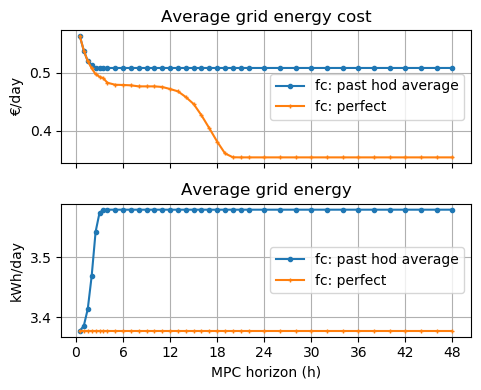

In [349]:
fig, (ax1,ax2) = subplots(2,1, figsize=(5, 4), sharex=true)

# sym = ""
sym1 = "o" # plot with dots
sym2 = "+" # plot with dots


ax1.plot(H_list*dt, C_grid_dm_H, "-$sym1", label="fc: past hod average", ms=3)
ax1.plot(H_list*dt, C_grid_per_H, "-$sym2", label="fc: perfect", ms=3)

ax1.set(
    title = "Average grid energy cost",
    ylabel = "€/day",
    # Zoom on first 3 hours:
    #xlim = (0,6),
    #ylim = (0.46, 0.57)
)

ax1.legend(loc="center right") # "upper right" for zoom
ax1.grid(true)

ax2.plot(H_list*dt, P_grid_dm_H, "-$sym1", label="fc: past hod average", ms=3)
ax2.plot(H_list*dt, P_grid_per_H, "-$sym2", label="fc: perfect", ms=3)

ax2.set(
    title = "Average grid energy",
    xlabel = "MPC horizon (h)",
    xticks = 0:6:48, # disable for zoom
    ylabel = "kWh/day",
)

ax2.legend(loc="center right")
ax2.grid(true)

fig.tight_layout()
fig.savefig("MPC_cost_horizon_effect.pdf", bbox_inches="tight")